## Imports & User-defined variables

In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
#this may take 20-30 seconds
import torch
import glob
import re
import os
import math
from random import sample
import shutil
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import metrics
import reciprocalspaceship as rs
from multiprocessing import Pool

from itertools import repeat
import gemmi
import valdo

pd.set_option("display.precision", 3)
plt.rc('figure', figsize=(4,2.5))
print("done with imports.")

done with imports.


In [3]:
bGPU, ncpu=valdo.helper.configure_session()

We will use GPU for torch operations (esp. VAE training).
There are 12 CPUs available.
For multiprocessing, we will use 11 CPUs.


### Set user-defined variables

In [4]:
include_errors = True        # whether to use SIGFs in the VAE loss function
stdof          = 16          # DOF for student t (None -> normal dist); only used when include_errors=True
eps            = 0.02         # the smaller eps (>=0), the more strongly estimated errors are taken into account (default: 0.01)
ref_mtz        = '0001.mtz'   # use a high-quality dataset as reference
min_cc_ref     = 0.6          # min correlation with the reference dataset. otherwise discarded.
mtzs_to_ignore = [] # MTZs to disregard; in this case, I don't have read permission for '0003.mtz'
random_seed    = 11231        # random seed for PyTorch and subsampling data (if any) 
fraction       = 1.0          # fraction of datasets to work with (default: 1.0)
train_fraction = 0.8          # fraction of working datasets used for training
blob_sig_cutoff= 3.5          # cutoff for blob search (our default: 3.5)
radius_in_A    = 4.0          # radius (in A) of the gaussian smoothing kernel; 3x the sigma (default: 5)

# VAE (most settings hardcoded below)
latent_dim     = 7            # VAE latent space dimension (default: 7)
epochs         = 300          # Number of VAE training epochs (default: 300)
run_prefix     = "run_" + str(random_seed) + "_"

In [5]:
# Seed the random number generator for reproducible behavior
# change the random seed for another realization of the optimization.
torch.manual_seed(random_seed)
np.random.seed(random_seed)

### Define Paths

In [6]:
#phyllis_dir="/n/holyscratch01/hekstra_lab/phyllis/"
my_dir     ="/n/holyscratch01/hekstra_lab/mhli/drug/"
original_data_path = my_dir + 'data/mtzs_origin/'

In [7]:
# general pattern for standardizing mtz filenames
mtz_file_pattern = r".*(\d{4}).*.mtz"

basepath = my_dir + 'pipeline/'
data_path      = basepath + 'data/'
input_mtz_path = basepath + 'data/mtzs_origin/'
reindexed_path = basepath + 'data/mtzs_reindex/'
scaled_path    = basepath + 'data/scaled/'

# These currently do not carry prefixes bc they will mostly be constant:
intersection_path = scaled_path + 'intersection.pkl'
union_path        = scaled_path + 'union.pkl'
sigF_path         = scaled_path + 'sigF.pkl'

vae_path = basepath + 'vae/'
vae_reconstructed_path             = vae_path + 'reconstructed/'
vae_reconstructed_with_phases_path = vae_path + 'reconstructed_w_phases/'
blob_path                          = vae_path + 'blobs/'

In [8]:
amplitude_col        = 'F-obs'
amplitude_scaled_col = 'F-obs-scaled'
error_col            = 'SIGF-obs'
error_scaled_col     = 'SIGF-obs-scaled'

recons_col = 'recons'
diff_col   = 'diff'
phase_2FOFC_col = 'refine_PH2FOFCWT'
phase_FOFC_col  = 'refine_PHFOFCWT'

In [9]:
#Added by DH
#refined_apo_mtzs_path   =phyllis_dir + 'pipeline/data/refined_mtzs/'
#refined_apo_pdbs_path   =phyllis_dir + 'pipeline/data/refined_models/'

#refine_stats            =phyllis_dir + 'pipeline/data/refine_stats.csv'

# Add a fallback model
# to do: an MTZ for cases where there was no refined model for some reason. 

If we want to compare to previously identified bound samples, we'll need this in Step 9.

In [ ]:
bound_models_path=phyllis_dir + "PTP1B_DK/all_bound_models_reindexed/"
bound_sample_ids =phyllis_dir + "bound_sample_ids.txt"

bound_models_standardized_path= basepath + 'data/bound_models_reindexed/'

#### Configure paths

In [9]:
# Make paths
# dir_hierarchy=[basepath, data_path, input_mtz_path, reindexed_path, scaled_path, vae_path, vae_reconstructed_path, \
#                vae_reconstructed_with_phases_path, blob_path, refined_apo_mtzs_path, refined_apo_pdbs_path,\
#                bound_models_standardized_path]
dir_hierarchy=[basepath, data_path, input_mtz_path, reindexed_path, scaled_path, vae_path, vae_reconstructed_path, \
               vae_reconstructed_with_phases_path, blob_path]
for folder in dir_hierarchy:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print("Created " + folder)
    else:
        print(folder + " already exists.")

/n/holyscratch01/hekstra_lab/mhli/drug/pipeline/ already exists.
/n/holyscratch01/hekstra_lab/mhli/drug/pipeline/data/ already exists.
/n/holyscratch01/hekstra_lab/mhli/drug/pipeline/data/mtzs_origin/ already exists.
/n/holyscratch01/hekstra_lab/mhli/drug/pipeline/data/mtzs_reindex/ already exists.
/n/holyscratch01/hekstra_lab/mhli/drug/pipeline/data/scaled/ already exists.
/n/holyscratch01/hekstra_lab/mhli/drug/pipeline/vae/ already exists.
/n/holyscratch01/hekstra_lab/mhli/drug/pipeline/vae/reconstructed/ already exists.
/n/holyscratch01/hekstra_lab/mhli/drug/pipeline/vae/reconstructed_w_phases/ already exists.
/n/holyscratch01/hekstra_lab/mhli/drug/pipeline/vae/blobs/ already exists.


## Step 1: Diffraction Data

The first step involves acquiring diffraction datasets in the `mtz` format. These datasets should follow a specific naming convention, where each file is named with a number followed by the `.mtz` extension (e.g., `0001.mtz`, `0002.mtz`, etc.).

### Usage

1. Ensure that you have collected diffraction datasets in the `mtz` format.

2. Organize the datasets with sequential numerical names (e.g., `0001.mtz`, `0002.mtz`, etc.). You can do so using the following cell.

3. If you have bound-state models already and you want to benchmark against those in Step 9 below, also run the cell `Application to bound state models (for Step 9)`. 

Following this naming convention will allow datasets to be ready for further processing.

### Copy and Renaming Code
_Only need to run the following cell once, can skip on rerun._

The following cell is a template for renaming files to the correct naming convention. Change `source_path`, `destination_path`, and extensions as necessary.

e.g. `source_path/PTP1B-y0798_mrflagsref_idxs.mtz` -> `destination_path/0798.mtz`

In [17]:
%%time
new_mtzs=valdo.helper.standardize_input_mtzs(source_path=original_data_path, 
                       destination_path=input_mtz_path, 
                       mtz_file_pattern=mtz_file_pattern, 
                       ncpu=ncpu)
print("\nCreated " + str(len(new_mtzs)) + " standardized MTZ files.")

Copying & renaming 1680 MTZ files from /n/holyscratch01/hekstra_lab/mhli/drug/data/mtzs_origin/ to /n/holyscratch01/hekstra_lab/mhli/drug/pipeline/data/mtzs_origin/

Created 1680 standardized MTZ files.
CPU times: user 36.3 ms, sys: 54.1 ms, total: 90.4 ms
Wall time: 1.2 s


#### Application to bound state models (for Step 9)
_Ignore this section if there are no prior bound state models. Only needs to be run once._

In [14]:
%%time
bSkip=True

if not bSkip:
    # Define the source and destination folders
    source_path      = bound_models_path
    destination_path = bound_models_standardized_path
    
    # Get a list of all files in the source folder
    file_list = os.listdir(source_path)
    # print(file_list)
    
    # Define a regular expression pattern to match the filenames
    pattern = r".*(\d{4}).*.pdb"
    
    # Iterate over each file in the source folder
    for filename in tqdm(file_list):
    
        # Check if the file matches the pattern
        match = re.match(pattern, filename)
        if match:
            # Extract the ID from the filename
            id = match.group(1)
            
            # Define the new filename
            new_filename = id + ".pdb"
            
            # Construct the full source and destination paths
            tmp_source_path = os.path.join(source_path, filename)
            tmp_destination_path = os.path.join(destination_path, new_filename)
            
            # Copy the file to the destination folder with the new name
            # print(source_path)
            # print(destination_path)
            try:
                shutil.copy(tmp_source_path, tmp_destination_path)
            except Exception as e:
                print(e)
        else:
            print("No match for " + filename)

100%|█████████████████████████████████████████| 189/189 [00:06<00:00, 28.21it/s]

CPU times: user 47.3 ms, sys: 142 ms, total: 189 ms
Wall time: 6.7 s


## Step 2: Reindexing & Scaling

This step focuses on reindexing and scaling a list of input MTZ files to a reference MTZ file using gemmi. 

**Reindexing:** The datasets provided may include samples indexed using different settings to describe the same crystal lattice. To ensure comparability, we reindex each sample to a common indexing scheme by applying reindexing operators. To set the common indexing scheme, we compare each dataset to a common reference dataset. This can be one of the better datasets in the screen.

**Scaling:** The samples are scaled to a reference dataset using a global anisotropic scaling factor by an analytical scaling method that determines the Debye-Waller Factor. The scaling process ensures that structure factor amplitudes are comparable across different datasets, accounting for variabilities such as differences in lattice orientations.

### Usage

1. Import the required library, `valdo`.

2. Call the `reindex_files()` function from `valdo.reindex`. The `reindex_files()` function will enumerate possible reindexing operations for any space group and apply them to each input MTZ file. It will select the operation with the highest correlation with the reference dataset. The reindexed files will be saved in the specified output folder, following the same `##.mtz` naming convention.

    This function can be called with the following parameters:
    - `input_files`: List of paths to input MTZ files to be reindexed.
    - `reference_file`: Path to the reference MTZ file.
    - `output_folder`: Path to the folder where the reindexed MTZ files will be saved.
    - `columns`: A list containing the names of the columns in the dataset that represent the amplitude and the error column.

3. Create a `Scaler` object by providing the path to the reference MTZ file.

4. Call the `batch_scaling()` method of the `Scaler` object. The `batch_scaling()` method will apply the scaling process to each input MTZ file and save the scaled MTZ files in the specified output folder. Scaling metrics, such as least squares values and correlations, will be saved in the report file.

    This function can be called with the following parameters:
    - `mtz_path_list`: List of paths to input MTZ files to be scaled.
    - `outputmtz_path`: Path to the folder where the scaled MTZ files will be saved (optional, default is `./scaled_mtzs/`).
    - `reportfile`: Path to the file where scaling metrics will be saved (optional, default is `./scaling_data.json`).
    - `verbose`: Whether to display verbose information during scaling (optional, default is `True`).
    - `n_iter`: Number of iterations for the analytical scaling method (optional, default is `5`).


### Reindexing Code
_Only need to run the following once, so can skip on rerun._

In [10]:
# List of files to be reindexed
file_list = glob.glob(input_mtz_path + "*mtz")
file_list.sort()

# print(file_list)
for mtz in mtzs_to_ignore:
    file_list.remove(input_mtz_path+mtz)
print("Working with " + str(len(file_list)) + " MTZ files.")

Working with 1680 MTZ files.


Select a good dataset as your reference (see the variable `ref_mtz` above).

**Critical**: The phases we will use below to calculate difference maps must come from models that have been indexed _consistent_ with the indexing convention chosen here (by the choice of our reference dataset). Otherwise, the difference maps will be meaningless!! An easy way to assure consistency is by obtaining the phases from refinement against the reindexed data!

In [11]:
reference_idx = file_list.index(input_mtz_path+ref_mtz)

In [12]:
%%time
# Reindexes a list of input MTZ files to a reference MTZ file using gemmi, took ~2min

if ncpu >1:
    reindexing_record=valdo.reindex.reindex_files_pool(input_files=file_list, 
                  reference_file=file_list[reference_idx], 
                  output_folder=reindexed_path,
                  columns=[amplitude_col, error_col],ncpu=ncpu)
else:
    reindexing_record=valdo.reindex.reindex_files(input_files=file_list, 
              reference_file=file_list[0], 
              output_folder=reindexed_path,
              columns=[amplitude_col, error_col])

print(*reindexing_record[:5], sep="\n")

100%|██████████| 1680/1680 [01:48<00:00, 15.47it/s]


[0, '/n/holyscratch01/hekstra_lab/mhli/drug/pipeline/data/mtzs_reindex/0001_0.mtz', [1.0, 0.12512246]]
[1, '/n/holyscratch01/hekstra_lab/mhli/drug/pipeline/data/mtzs_reindex/0002_1.mtz', [0.09678379, 0.7971291]]
[1, '/n/holyscratch01/hekstra_lab/mhli/drug/pipeline/data/mtzs_reindex/0003_1.mtz', [0.048187964, 0.9276802]]
[0, '/n/holyscratch01/hekstra_lab/mhli/drug/pipeline/data/mtzs_reindex/0004_0.mtz', [0.6655307, 0.089041926]]
[0, '/n/holyscratch01/hekstra_lab/mhli/drug/pipeline/data/mtzs_reindex/0006_0.mtz', [0.9472914, 0.117432855]]
CPU times: user 439 ms, sys: 112 ms, total: 551 ms
Wall time: 2min 35s


If reindexing is relevant, it is good to check the gap in correlation coefficients with the reference across indexing solutions. In the case of PTP-1B, any gap < 0.15 seems suspicious.

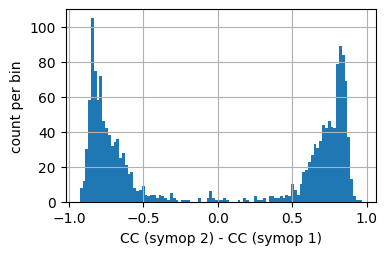

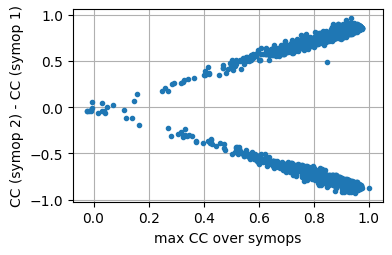

In [13]:
if len(reindexing_record[0][2]) > 1:
    CC_dif=[x[2][1]-x[2][0] for x in reindexing_record]
    CC_max=[np.amax(x[2]) for x in reindexing_record]
    plt.grid()
    plt.hist(CC_dif,100)
    plt.xlabel("CC (symop 2) - CC (symop 1)")
    plt.ylabel("count per bin")
    plt.show()
    
    plt.grid()
    plt.plot(CC_max, CC_dif,'.')
    plt.ylabel("CC (symop 2) - CC (symop 1)")
    plt.xlabel("max CC over symops")
    plt.show()

### Scaling Code
_Only need to run the following cell once, can skip on rerun._

In [14]:
file_list = glob.glob(reindexed_path + "*mtz")
file_list.sort()
print("We have " + str(len(file_list)) + " reindexed MTZ files.")

We have 1680 reindexed MTZ files.


The following optimization of scales sometimes generates numerical warnings about overflows. Let us know if this happens a lot. Without parallelization, this takes about 0.25s/dataset.

In [15]:
%%time
# Scales all datasets to the previously provided reference, writes a `metrics.pkl`, take ~30s
# Returns some metrics on the quality of the dataset.
if ncpu > 1:
    scaler = valdo.Scaler_pool(reference_mtz=file_list[reference_idx],columns=[amplitude_col, error_col],verbose=False, n_iter=5,ncpu=ncpu)
    scaling_metrics = scaler.batch_scaling(mtz_path_list=file_list, 
                                   outputmtz_path=scaled_path,
                                   prefix=run_prefix)
else:
    scaler = valdo.Scaler(reference_mtz=file_list[reference_idx])
    scaling_metrics = scaler.batch_scaling(mtz_path_list=file_list, 
                                   outputmtz_path=scaled_path,
                                   prefix=run_prefix, 
                                   verbose=False)

  0%|          | 0/1680 [00:00<?, ?it/s]/n/holyscratch01/hekstra_lab/mhli/drug/drug-screening/valdo/scaling.py:191: RuntimeWarning: overflow encountered in exp
  FB_scaled = np.exp(ln_k) * np.exp(-args) * FB
/n/holyscratch01/hekstra_lab/mhli/drug/drug-screening/valdo/scaling.py:191: RuntimeWarning: invalid value encountered in multiply
  FB_scaled = np.exp(ln_k) * np.exp(-args) * FB
/n/holyscratch01/hekstra_lab/mhli/drug/drug-screening/valdo/scaling.py:191: RuntimeWarning: overflow encountered in exp
  FB_scaled = np.exp(ln_k) * np.exp(-args) * FB
/n/holyscratch01/hekstra_lab/mhli/drug/drug-screening/valdo/scaling.py:191: RuntimeWarning: invalid value encountered in multiply
  FB_scaled = np.exp(ln_k) * np.exp(-args) * FB
/n/holyscratch01/hekstra_lab/mhli/drug/drug-screening/valdo/scaling.py:191: RuntimeWarning: overflow encountered in exp
  FB_scaled = np.exp(ln_k) * np.exp(-args) * FB
/n/holyscratch01/hekstra_lab/mhli/drug/drug-screening/valdo/scaling.py:191: RuntimeWarning: invalid 

CPU times: user 203 ms, sys: 98.9 ms, total: 302 ms
Wall time: 44.2 s


In [16]:
scaling_metrics.head(5)

,file,start_LS,start_corr,end_LS,end_corr
0,0001_0,0.000e+00,1.000,0.000e+00,1.000
1,0002_1,3.338e+06,0.955,1.198e+06,0.955
2,0003_1,9.513e+06,0.980,5.661e+05,0.980
3,0004_0,6.935e+06,0.873,4.336e+06,0.873
4,0006_0,1.879e+06,0.996,9.389e+04,0.996


## Step 3: Normalization & Preparation of VAE input

This step involves normalizing the scaled structure factor amplitudes obtained in the previous step. The input is restricted to only those Miller indices present in the _intersection_ of all datasets, and the VAE will predicts structure factor amplitudes for all Miller indices in the _union_ of all datasets.

Additionally, we standardize all the input data, such that the structure factor amplitudes for each Miller index in the union of all datasets have a mean of zero and a unit variance across datasets. 

### Usage

1. Import the required library, `valdo.preprocessing`.

2. Find the intersection and union of the scaled datasets using the following functions:

   - `find_intersection()`: Finds the intersection of `amplitude_col` from multiple input MTZ files and saves the result to the specified output pickle file. Arguments include the following:

      - `input_files`: List of input MTZ file paths.
      - `output_path`: Path to save the output pickle file containing the intersection data.
      - `amplitude_col`: Name of the column in the dataset that represents the scaled amplitude (default is 'F-obs-scaled').

   - `find_union()`: Finds the union of `amplitude_col` from multiple input MTZ files and saves the result to the specified output pickle file. Arguments are the same as `find_intersection()`.

3. Generate the VAE input and output data using the `generate_vae_io()` function. This standardizes the intersection dataset using mean and standard deviation calculated from the union dataset. The standardized intersection becomes the VAE input, while the standardized union becomes the VAE output. Both the VAE input and output are saved to the specified folder. 

    This function can be called with the following parameters:

    - `intersection_path`: Path to the intersection dataset pickle file.
    - `union_path`: Path to the union dataset pickle file.
    - `io_path`: Path to the output folder where the VAE input and output will be saved. Mean and standard deviation data calculated from the union dataset will also be saved in this folder as `union_mean.pkl` and `union_sd.pkl`.

### Filtering Samples Code

_Only need to run this code once, can skip on rerun._

In this example, we remove samples with low `end_corr`. This ensures that our VAE is trained with high quality samples.

In [21]:
# Identify all scaled files to use as input and output for the VAE

file_list = glob.glob(scaled_path + "*mtz")
file_list.sort()
print("Current file list contains " + str(len(file_list)) + " entries.")

Current file list contains 1680 entries.


This following cell removes samples with `end_corr < min_cc_ref` or if `end_corr = NA`.

In [22]:
metrics_df = pd.read_pickle(scaled_path + run_prefix + "scaling_metrics.pkl")

# moved formatting into scaling fcn
metrics_df[metrics_df.isna().any(axis=1)]
low_corr_files = list(metrics_df[(metrics_df['end_corr'] < min_cc_ref) | (metrics_df['end_corr'].isnull())]['file'])
low_corr_files = [scaled_path + x + '.mtz' for x in low_corr_files]
file_list = [file for file in file_list if file not in low_corr_files]

with open(os.path.join(vae_path, 'filtered_file_list.pkl'), 'wb') as f:
    pickle.dump(file_list, f)
print("The file list contains " + str(len(file_list)) + " entries after filtering.")

The file list contains 1612 entries after filtering.


##### For testing purposes, we will subsample the list of entries.

In [29]:
if fraction < fraction:
    file_list = sample(file_list, int(fraction * len(file_list)))
print("Subsampling " + str(len(file_list)) + " entries.")

Subsampling 1611 entries.


### Generating VAE Input

The following cells generate the VAE input and output. The first cell takes about 3 min for PTP1B; the second one about 10 min (both on a CPU).

**Together, these two steps are the slowest part of the pipeline (when using multiple cpu). Please be patient!**
If you are not changing anything about scaling or dataset filtering, you can skip them next time!

In [23]:
%%time
# Creates an `intersection.pkl` file at the specified path
# This is the intersection of all the scaled files provided
valdo.preprocessing.find_intersection(input_files=file_list, 
                  output_path=intersection_path,
                  amplitude_col=amplitude_scaled_col)

100%|██████████| 1612/1612 [00:35<00:00, 44.89it/s]


CPU times: user 1min 44s, sys: 4.42 s, total: 1min 49s
Wall time: 1min 49s


In [24]:
%%time
# Creates a `union.mtz` file at the specified path
# This is the union of all the scaled files provided
# This is a lot slower than the intersection step about. The step is 
#   about linear in the number of files, 0.5 sec/file on my CPU.
# Inclusion of errors does not affect speed -- *always include them*

valdo.preprocessing.find_union(input_files=file_list, 
                               output_path=union_path,
                               sigF_path=sigF_path,
                               amplitude_col=amplitude_scaled_col, 
                               include_errors=True)

Done reading in 1612 files (disregarding errors); now starting concatenation. Please be patient.
CPU times: user 6min 33s, sys: 9.87 s, total: 6min 43s
Wall time: 6min 44s


In [25]:
%%time
# Generates VAE input and output data from the intersection and union datasets
# Inclusion of errors does not affect speed => always include them here.
# Note that we do not currently prefix the VAE input
valdo.preprocessing.generate_vae_io(intersection_path=intersection_path, 
                                    union_path=union_path, 
                                    sigF_path=sigF_path,
                                    io_folder=vae_path, 
                                    prefix="", 
                                    include_errors=True)

/n/home06/minhuan/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Size of vae_output (training data): (1612, 77821)
Size of mean across datasets: (77821,)
Size of stdev across datasets: (77821,)
Size of vae_input (training data): (1612, 2796)
Size of vae_sigF (like training data): (1612, 77821)
Created starting files for VAE in /n/holyscratch01/hekstra_lab/mhli/drug/pipeline/vae/ with prefix = 
CPU times: user 1min 11s, sys: 5.47 s, total: 1min 16s
Wall time: 1min 16s


## Step 4: VAE Training

In this step, we train the VAE model using the provided VAE class.

### Usage

1. Load the VAE input and output data that was generated in the previous step.

2. Initialize the VAE model with the desired hyperparameters. Tune-able hyperparameters include the following:
    - `n_dim_latent`: Number of dimensionality in latent space (optional, default `1`)

    - `n_hidden_layers`: Number of hidden layers in the encoder and decoder. If an int is given, it will applied to both encoder and decoder; If a length 2 list is given, first int will be used for encoder, the second will be used for decoder

    - `n_hidden_size`: Number of units in hidden layers. If an int is given, it will be applied to all hidden layers in both encoder and decoder; otherwise, an array with length equal to the number of hidden layers can be given, the number of units will be assigned accordingly.

    - `activation` : Activation function for the hidden layers (optional, default `tanh`)

3. Split the data into training and validation sets. Randomly select a subset of indices for training and use the rest for validation.

4. Convert the data into PyTorch tensors.

5. Set up the optimizer for training.

6. Train the VAE model using the `train()` method. The training process involves minimizing the ELBO (Evidence Lower Bound) loss function, which consists of a Negative Log-Likelihood (NLL) term and a Kullback-Leibler (KL) divergence term. Arguments used in this function include:

    - `x_train`: Input data for training the VAE, a PyTorch tensor representing the VAE input data. 

    - `y_train`: Output data for training the VAE, a PyTorch tensor representing the VAE output data. 

    - `optim`: The optimizer used for training the VAE, a PyTorch optimizer object, such as `torch.optim.Adam`, that specifies the optimization algorithm and its hyperparameters, including the learning rate (`lr`).

    - `x_val`: Input data for validation during training. (optional, default is `None`).

    - `y_val`: Output data for validation during training. (optional, default is `None`).

    - `epochs`: The number of training epochs (epoch: a single pass through the data).

    - `batch_size`: The batch size used during training. If an integer is provided, the same batch size will be used for all epochs. If a list of integers is provided, it should have the same length as the number of epochs, and each value in the list will be used as the batch size for the corresponding epoch. Default is `256`.

    - `w_kl`: The weight of the Kullback-Leibler (KL) divergence term in the ELBO loss function. The KL divergence term encourages the latent distribution to be close to a prior distribution (usually a standard normal distribution). A higher value of `w_kl` will increase the regularization strength on the latent space. Default is `1.0`.
    - `include_errors`, `eps`, `stdof`: when including errors, the loss will be weighted by the errors in the observed amplitudes. A small fixed amount, `eps` can be added to these error estimates to diminish the contribution of the reflections with very small sigF (e.g. around 0.005 after normalization). `stdof` toggles the loss function between Student t (finite `stdof`) and Normal (`stdof=None`).

    **Note:** The VAE class internally keeps track of the training loss (`loss_train`) and its components (NLL and KL divergence) during each batch of training. These values can be accessed after training to monitor the training progress and performance. The `loss_train` attribute of the VAE object will be a list containing the training loss values for each batch during training. The `loss_names` attribute contains the names of the loss components: "Loss", "NLL", and "KL_div". These attributes are updated during training and can be used for analysis or visualization.

7. Save the trained VAE model for future use (optional).

### Code

In [26]:
# Load the VAE I/O Files Generated
# note that we do not use a prefix since these files are likely to change less frequently than the runs.
vae_input  = np.load(vae_path + 'vae_input.npy')
vae_output = np.load(vae_path + 'vae_output.npy')
vae_sigF   = np.load(vae_path + 'vae_sigF.npy')

In [27]:
# Sanity checks
print(vae_input.shape)
print(vae_output.shape)
print(vae_sigF.shape)

(1612, 2796)
(1612, 77821)
(1612, 77821)


In [34]:
# If you want to see the training target in all its glory...
# union = pd.read_pickle(union_path)
# union.iloc[:5,:20]

# or the (normalized) sigF
# sigF = pd.read_pickle(sigF_path)
# sigF.iloc[:5,:20]

# SNR_ratio = sigF.iloc[:500,:500].values.flatten()/union.iloc[:500,:500].values.flatten()

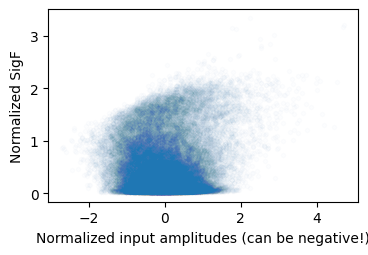

In [30]:
plt.plot(vae_output[10,:],vae_sigF[10,:],'.',alpha=0.01)
plt.xlabel("Normalized input amplitudes (can be negative!)")
plt.ylabel("Normalized SigF")
plt.show()

#### Setting up the VAE

In [31]:
%%time
# Specify VAE Parameters; takes ~1 sec
# Only execute once. Otherwise it may throw an error.Restart kernel if this cell throws an error
latent_dimension = latent_dim
train_fraction = train_fraction
epochs = epochs # default: 300

vae = valdo.VAE(n_dim_i = vae_input.shape[1], 
      n_dim_o = vae_output.shape[1], 
      n_dim_latent = latent_dimension, 
      n_hidden_layers = [3, 6], 
      n_hidden_size = 100, 
      activation = torch.relu)

# Randomly select (train_fraction) indices for training
choice = np.random.choice(vae_input.shape[0], int(train_fraction*vae_input.shape[0]), replace=False)    
train_ind = np.zeros(vae_input.shape[0], dtype=bool)
train_ind[choice] = True
test_ind = ~train_ind
print("Size of training set = " + str(np.sum(train_ind)))
print("Size of test set = " + str(np.sum(test_ind)))

# Split the input and output data into training and validation sets
x_train, x_val = vae_input[train_ind], vae_input[test_ind]
y_train, y_val = vae_output[train_ind], vae_output[test_ind]
e_train, e_val = vae_sigF[train_ind], vae_sigF[test_ind] # error estimates for y

# Convert the data to torch tensors
x_train, x_val, y_train, y_val, e_train, e_val = torch.tensor(x_train), torch.tensor(x_val), \
                                                 torch.tensor(y_train), torch.tensor(y_val), \
                                                 torch.tensor(e_train), torch.tensor(e_val)

Size of training set = 1289
Size of test set = 323
CPU times: user 1.35 s, sys: 476 ms, total: 1.83 s
Wall time: 20.1 s


#### Training the VAE

In [32]:
%%time
# Set up the optimizer and train the VAE
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
vae.train(x_train, y_train, e_train, optimizer, x_val, y_val, e_val, epochs=epochs, 
          batch_size=100, w_kl=1.0,
          eps=eps,
          include_errors=include_errors,
          stdof=stdof, 
          verbose=True)

Ep 300: 100%|██████████| 13/13 [00:00<00:00, 14.47it/s, Test=3.13e+5, Train=2.7e+5, mem=0.618] 

CPU times: user 4min 33s, sys: 1.32 s, total: 4min 34s
Wall time: 4min 52s


In [33]:
# Save the trained VAE model
vae.save(vae_path + run_prefix + 'trained_vae.pkl')
# vae.save(vae_path + 'trained_vae_student_t.pkl')

#### VAE loss traces

The following cells allow us to visualize the loss over epochs.

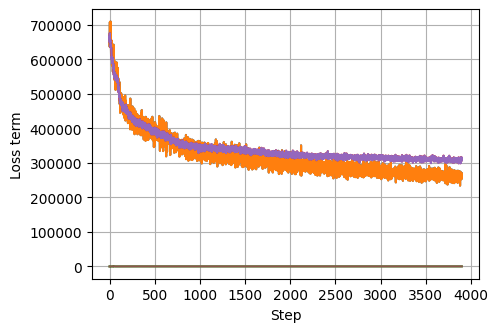

In [34]:
vae = valdo.VAE.load(vae_path + run_prefix + 'trained_vae.pkl')
loss_array = np.array(vae.loss_train)
plt.figure(figsize=(5,3.5))
plt.plot(loss_array)
plt.xlabel("Step")
plt.ylabel("Loss term")
plt.grid()
plt.show()

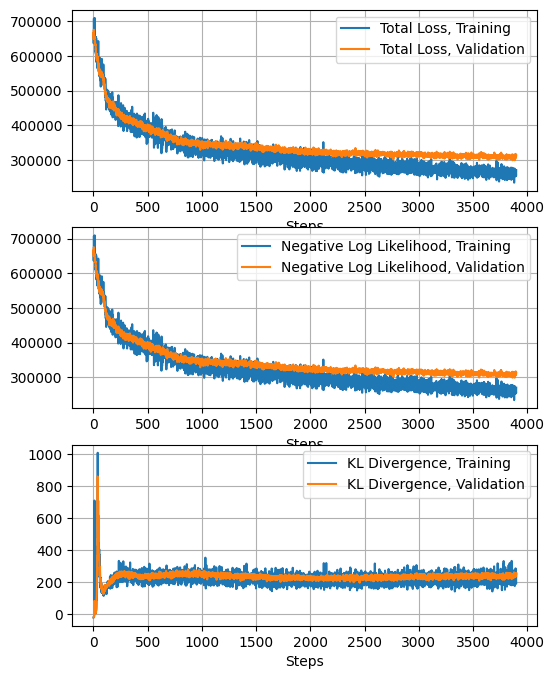

In [35]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=[6,8])
ax = axs.reshape(-1)

ax[0].plot(loss_array[:,0], label='Total Loss, Training')
ax[0].plot(loss_array[:,3], label='Total Loss, Validation')
ax[0].set_xlabel("Steps")
ax[0].grid()
ax[0].legend()

ax[1].plot(loss_array[:,1], label='Negative Log Likelihood, Training')
ax[1].plot(loss_array[:,4], label='Negative Log Likelihood, Validation')
ax[1].set_xlabel("Steps")
ax[1].grid()
ax[1].legend()

ax[2].plot(loss_array[:,2], label='KL Divergence, Training')
ax[2].plot(loss_array[:,5], label='KL Divergence, Validation')
ax[2].set_xlabel("Steps")
ax[2].grid()
ax[2].legend()

plt.show()

## Steps 5 & 6: Reconstruction of "Apo" Data & Calculating Difference Maps

In this step, VAE outputs are re-scaled accordingly to recover the original scale, and differences in amplitudes between the original and reconstructed data are calculated. A `recons` and a `diff` column will be created for all datasets.

### Usage

To perform the reconstruction, or re-scaling, the `rescale()` function can be called, providing the necessary arguments:

- `recons_path`: Path to the reconstructed output of the VAE in NumPy format.
- `intersection_path`: Path to the pickle file containing the intersection of all scaled datasets.
- `union_path`: Path to the pickle file containing the union data of all scaled datasets.
- `input_files`: List of input file paths. This list should be in the same order as is in the `vae_input.npy` or `intersection.mtz`.
- `info_path`: Path to the folder containing files with the mean and SD used for standardization previously.
- `output_path`: Path to the folder where the reconstructed data will be saved.
- `amplitude_col`: Column in the MTZ file that contains structure factor amplitudes to calculate the difference column.

### Code
_Loads its inputs, saves its outputs._

In [36]:
# Load trained VAE
# vae = valdo.VAE.load(vae_path + run_prefix + 'trained_vae.pkl')
vae = valdo.VAE.load(vae_path + run_prefix + 'trained_vae.pkl')

In [37]:
# Load input file and create a tensor

# vae_input = np.load(vae_path + run_prefix + 'vae_input.npy')
vae_input = np.load(vae_path + 'vae_input.npy')
vae_input_tensor = torch.tensor(vae_input)
if bGPU:
    vae_input_tensor = vae_input_tensor.to("cuda:0")

In [40]:
# Reconstruct the input file via VAE, convert to numpy, and save

recons = vae.reconstruct(vae_input_tensor)
recons = recons.detach().cpu().numpy()
np.save(vae_reconstructed_path + 'recons', recons)

In the following step we put the reconstructed amplitudes back on the same scale as the input data. This step can crash the kernel/session if not enough memory is available. In that case, try reducing ncpu below the available number of CPUs.

In [14]:
%%time
# Re-scale the reconstructed files accordingly and creates the `diff` column
# Function is valdo.preprocessing.rescale

ncpu_temp=8

with open(os.path.join(vae_path, 'filtered_file_list.pkl'),'rb') as f:
    file_list = pickle.load(f)

print(len(file_list))

if ncpu > 1:
    valdo.preprocessing.rescale_pool(recons_path=vae_reconstructed_path + 'recons.npy', 
                intersection_path=intersection_path, 
                union_path=union_path, 
                input_files=file_list, 
                info_folder=vae_path, 
                output_folder=vae_reconstructed_path,
                amplitude_col="F-obs-scaled",
                ncpu=ncpu_temp)
else:
    valdo.preprocessing.rescale(recons_path=vae_reconstructed_path + 'recons.npy', 
                intersection_path=intersection_path, 
                union_path=union_path, 
                input_files=file_list, 
                info_folder=vae_path, 
                output_folder=vae_reconstructed_path,
                amplitude_col="F-obs-scaled")

1611
Done rescaling.
CPU times: user 6.95 s, sys: 11.6 s, total: 18.5 s
Wall time: 55.1 s


## Steps 7 & 8: Gaussian Blurring & Searching for Blobs

**Note Regarding Phases:** In this section, phases are required for each dataset. You can obtain phases by completing refinement via PHENIX for each dataset, and utilizing those phases.

**Note Regarding Models:** In this section, models are also required for each dataset. These can also be obtained by refinement via PHENIX for each dataset, and they should be stored in a single folder, with the same naming convention (i.e. ##.mtz).

We offer a command-line tool for automatic refinement using PHENIX. Based on our tests, starting with a single apo model yields satisfactory phases and models for the following real-space maps. You can find an example refine_drug.eff file in the notebook/ directory.

*Code Example:* `valdo.refine --pdbpath "xxx/xxx_apo.pdb" --mtzpath "xxx/*.mtz" --output "yyy/" --eff "xxx/refine_drug.eff"`

In this step, we aim to identify significant changes in electron density caused by ligand binding to a protein. By taking the absolute value of the electron density difference maps and applying Gaussian blurring, a new map is created with merged positive electron density blobs. The blurring process attempts to reduce noise. Blobs are then identified and characterized above a specified contour level and volume threshold.

### Usage

To generate blobs from electron density maps, call the `generate_blobs()` function, which takes electron density map files and corresponding refined protein models as inputs. The function preprocesses the maps and identifies blobs above a specified contour level and volume threshold (the volume threshold is the default set by `gemmi`). The output is a DataFrame containing statistics for each identified blob, including peak value, score, centroid coordinates, volume, and radius. 

This function can be called with the following arguments:

- `input_files`: List of input file paths.
- `model_path`: Path to the folder containing the refined models for each dataset (pdb format).
- `diff_col`: Name of the column representing diffraction values in the input MTZ files.
- `phase_col`: Name of the column representing phase values in the input MTZ files.
- `output_path`: Path to the output folder where the blob statistics DataFrame will be saved.
- `cutoff`: Blob cutoff value. Blobs with values below this cutoff will be ignored (optional, default is `5`).
- `negate`: Whether to negate the blob statistics (optional, default is `False`). Use True if there is interest in both positive and negative peaks, which is not typically of interest here due to the absolute value function applied to the map.
- `sample_rate`: Sample rate for generating the grid in the FFT process (optional, default is `3`).

### Code

The following cell **adds phases** to our newly reconstructed datasets. These phases are copied from `../../pipeline/data/refined_mtzs/` which were generated via PHENIX.

In [11]:
print(refined_apo_mtzs_path)
print(vae_reconstructed_with_phases_path)

/n/holyscratch01/hekstra_lab/phyllis/pipeline/data/refined_mtzs/
/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/vae/reconstructed_w_phases/


Timing estimate: The following proceeds at about 8 files/second on a single GPU.

In [12]:
%%time
# List of reconstructed mtz files without phases to add phases to

file_list = glob.glob(vae_reconstructed_path + "*.mtz")
file_list_w_phases = file_list.copy()
print("Working with " + str(len(file_list)) + " MTZs containing reconstructed (apo-like) amplitudes.")

if ncpu > 1:
    results = valdo.helper.add_phases_pool(file_list, 
                                           refined_apo_mtzs_path, 
                                           vae_reconstructed_with_phases_path, 
                                           phase_2FOFC_col_out=phase_2FOFC_col, phase_FOFC_col_out=phase_FOFC_col,
                                           phase_2FOFC_col_in ='PH2FOFCWT', phase_FOFC_col_in ='PHFOFCWT',
                                           prefix=run_prefix, 
                                           ncpu=ncpu)
    print(results.head())
else:
    no_phases_files = valdo.helper.add_phases(file_list, refined_apo_mtzs_path, vae_reconstructed_with_phases_path, 
                              phase_2FOFC_col_out=phase_2FOFC_col, phase_FOFC_col_out=phase_FOFC_col,
                              phase_2FOFC_col_in ='PH2FOFCWT', phase_FOFC_col_in ='PHFOFCWT')
    print("Done. No phases found for " + str(len(no_phases_files)) + " starting MTZs.")

Working with 1612 MTZs containing reconstructed (apo-like) amplitudes.
                                                file  success
0  /n/holyscratch01/hekstra_lab/dhekstra/valdo-te...     True
1  /n/holyscratch01/hekstra_lab/dhekstra/valdo-te...     True
2  /n/holyscratch01/hekstra_lab/dhekstra/valdo-te...     True
3  /n/holyscratch01/hekstra_lab/dhekstra/valdo-te...     True
4  /n/holyscratch01/hekstra_lab/dhekstra/valdo-te...    False
CPU times: user 273 ms, sys: 278 ms, total: 550 ms
Wall time: 8.14 s


In [13]:
file_list = glob.glob(vae_reconstructed_with_phases_path + "*.mtz")
print("Working with " + str(len(file_list)) + " MTZs containing reconstructed (apo-like) amplitudes.")

result = valdo.helper.add_weights(file_list, 
                                  sigF_col="SIGF-obs", 
                                  diff_col="diff",
                                  sigdF_pct=95, 
                                  absdF_pct=99.5,
                                  redo=True,
                                  ncpu=ncpu)
print("Added weights and weighted differences to " + str(sum(result)) + " MTZ files.")

Working with 1572 MTZs containing reconstructed (apo-like) amplitudes.
Added weights and weighted differences to 1572 MTZ files.


The following two cells complete gaussian blurring and blob searching. For the blurring, by default, he radius is set to `5A` with `sigma = 5/3`.

In [14]:
# List of reconstructed mtz files (with phases) to identify blobs in
# tmp="/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline_run2/vae/reconstructed_w_phases/"

# usually vae_reconstructed_with_phases_path rather than tmp
file_list = glob.glob(vae_reconstructed_with_phases_path + "*mtz")
print("Retrieving " + str(len(file_list)) + " files for blob analysis.")

Retrieving 1572 files for blob analysis.


The following takes about 0.3 s/dataset on a single CPU for PTP1B and will scale with the number of voxels.

In [15]:
%%time
# Function in valdo.blobs that generates a list of blobs

if ncpu>1:
    valdo.blobs.generate_blobs_pool(input_files=file_list, 
                   model_folder=refined_apo_pdbs_path, 
                   diff_col='WDF', # DEFAULT is "diff"!!!!
                   phase_col='refine_PH2FOFCWT', 
                   output_folder=blob_path, 
                   prefix=run_prefix,
                   cutoff=blob_sig_cutoff,
                   radius_in_A=radius_in_A,
                   ncpu=ncpu)
else:
    valdo.blobs.generate_blobs(input_files=file_list, 
                   model_folder=refined_apo_pdbs_path, 
                   diff_col='diff', 
                   phase_col='refine_PH2FOFCWT', 
                   output_folder=blob_path, 
                   prefix=run_prefix,
                   cutoff=blob_sig_cutoff,
                   radius_in_A=radius_in_A)

Done generating blobs with starmap/pool and wrote /n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/vae/blobs/run_15_11231_blob_stats.pkl
CPU times: user 888 ms, sys: 455 ms, total: 1.34 s
Wall time: 19 s


## Step 9: Identifying Events

In this final step, the highest scoring blobs returned in the previous step can be analyzed individually. If the blob is plausibly a ligand, refinement with a ligand may be completed to determine whether or not the blob can be considered a "hit."

Blobs that are returned can be related to various other events, not just ligand binding. Examples may include ligand-induced conformational change (which would still indicate the presence of a ligand) or various other unrelated conformational changes, such as radiation damage or, for example for PTP1B, cysteine oxidation.

In the following example, we have also included the evaluation of our method, via AUC, in this section.

### Tagging Blobs

In this section, we tag and filter the blobs. We remove...

- blobs that are duplicates (we occassionally have duplicate blobs due to an issue with gemmi's ASU mask)
- blobs associated with the oxidation of `cys215`
- blobs that belong to low quality samples (high r factors in refinement)
- blobs that belong to samples with inconsistent data (in particular, Helen Ginn lists a few samples as hits without including a ligand in their bound state).

We also label blobs that are close to ligand positions known from a previous PanDDA analysis.

In [11]:
blob_df = pd.read_pickle(blob_path + run_prefix + 'blob_stats.pkl')
blob_df.head(5)

,sample,peakz,peak,score,cenx,ceny,cenz,volume,radius
0,1505,4.270,4.270,83.227,0.588,52.675,-1.081,22.128,1.742
1,1505,4.604,4.604,72.300,-7.821,70.558,0.807,18.343,1.636
2,1505,3.917,3.917,52.527,-1.090,52.742,34.742,14.267,1.505
3,0352,4.012,4.012,95.877,26.593,19.822,14.932,25.927,1.836
4,0352,4.115,4.115,84.462,26.863,17.597,22.634,22.645,1.755


Tag Samples that are known to contain a ligand (``Bound''): (1 if bound, 0 otherwise). Based on a previous PanDDA analysis. You can skip this if no such analysis!

In [12]:
with open(bound_sample_ids) as f:
    bound_samples = set([line.strip() for line in f])

# Set the "bound" column based on whether or not each sample is in the bound samples list
blob_df["bound"] = blob_df["sample"].apply(lambda x: 1 if x in bound_samples else 0)

In the case of PTP-1B, the catalytic cysteine, residue 215, is prone to oxidation with levels varying among datasets. To get rid of these false positives, we tag Samples within 3A of a Cys215 Atom (1 if within, 0 otherwise). You can use/adapt `valdo.tag.tag_blobs_around_seqid` more generally to omit certain regions.

In [13]:
%%time
#with one CPU, this takes about 40 sec

blob_df = valdo.tag.tag_blobs_around_seqid(blob_df, 
                                           refined_apo_pdbs_path, 
                                           radius=3, 
                                           tag='cys215', 
                                           focal_seqid=215, 
                                           ncpu=ncpu)

CPU times: user 541 ms, sys: 389 ms, total: 930 ms
Wall time: 3.34 s


In the case of PTP-1B, we already had an analysis by Keedy et al in hand using PanDDA. Here we tag samples within `r` of a known LIG atom (1 if yes, 0 otherwise). Fortunately, in all their bound models, the ligand "residue name" was LIG.

In [14]:
%%time
blob_df = valdo.tag.tag_lig_blobs(blob_df, 
                                  bound_models_standardized_path,
                                  ncpu=ncpu)

CPU times: user 373 ms, sys: 316 ms, total: 689 ms
Wall time: 950 ms


We use GEMMI under the hood to restrict blobs to a single asymmetric unit. Sometimes, however, we still double-include blobs if they are not in the exact same position. Here we tag Blobs that are Duplicates of Other Blobs (a.k.a. Patch for Gemmi's ASU Mask Issue).

In [16]:
%%time
# Identifies all possible cartesian coordinates after symmetry operations
# blob_df[['fractional', 'all_possible_frac', 'all_possible_cart']] = blob_df.apply(determine_locations, args=(vae_reconstructed_with_phases_path,), axis=1)
blob_df = valdo.tag.determine_locations(blob_df, vae_reconstructed_with_phases_path, ncpu=ncpu)
# blob_df.info()

CPU times: user 4.42 s, sys: 1.29 s, total: 5.71 s
Wall time: 33.2 s


In [17]:
%%time 
# <1 sec
# Marks blobs as duplicates if they are within 1A of another blob in the same sample
blob_df = valdo.tag.mark_duplicates(blob_df)

CPU times: user 571 ms, sys: 71.3 ms, total: 642 ms
Wall time: 625 ms


Let's look at some summary statistics so far.

In [18]:
blob_df.describe()

,peakz,peak,score,cenx,ceny,cenz,volume,radius,bound,cys215,ligand,duplicate
count,17212.000,17212.000,17212.000,17212.000,17212.000,17212.000,17212.000,17212.000,17212.000,17212.000,17212.000,17212.000
mean,5.454,5.454,226.412,4.478,42.523,15.693,50.484,1.969,0.080,0.058,0.014,0.036
std,2.038,2.038,567.039,15.928,16.444,12.718,107.155,0.747,0.272,0.234,0.118,0.185
min,3.691,3.691,36.486,-33.264,-2.309,-11.766,10.000,1.337,0.000,0.000,0.000,0.000
25%,4.492,4.492,56.129,-6.806,34.942,3.125,14.070,1.498,0.000,0.000,0.000,0.000
50%,4.996,4.996,87.903,2.409,44.517,13.920,21.739,1.731,0.000,0.000,0.000,0.000
75%,5.735,5.735,169.005,11.335,52.404,27.933,41.340,2.145,0.000,0.000,0.000,0.000
max,38.641,38.641,8997.621,49.995,80.925,46.714,1684.612,7.381,1.000,1.000,1.000,1.000


Tag Blobs Belonging to Samples with High R Factors

In [19]:
# In this case, no blobs are removed
high_rfree=0.40 # currently not used for filtering

r_factors = pd.read_csv(refine_stats)[['data_id', 'Rfree_final']]
high_r_factors = r_factors.loc[r_factors['Rfree_final'] > high_rfree, 'data_id'].astype(str).str.zfill(4)
blob_df['high_r_factor'] = blob_df['sample'].isin(list(high_r_factors))
print("Number of datasets with Rfree > " +str(high_rfree) + " = " +str(blob_df['high_r_factor'].sum()))

Number of datasets with Rfree > 0.4 = 46


In [20]:
blob_df.to_pickle(blob_path + run_prefix + 'blob_stats_tagged.pkl')

### Filter Blobs 
Remove blobs near Cys215, with high R_free, duplicates, and more as specified below.

In [25]:
blob_df = pd.read_pickle(blob_path + run_prefix +'blob_stats_tagged.pkl')

In [26]:
# Remove all samples where Helen Ginn does not include a bound state model
# In this case, there are no blobs.

hg_no_lig = ['0060', '1429', '1733', '1791', '0225', '0432', '0710']
blob_df = blob_df[~blob_df['sample'].isin(hg_no_lig)] 

In [27]:
# Remove Cys215 related blobs, blobs in samples with high R factors, and duplicates

blob_df = blob_df[(blob_df['cys215']==0) & (blob_df['high_r_factor']==0) & (blob_df['duplicate']==0)]   

Let's look at the filtered set of blobs:

In [28]:
blob_df.describe()

,peakz,peak,score,cenx,ceny,cenz,volume,radius,bound,cys215,ligand,duplicate
count,15511.000,15511.000,15511.000,15511.000,15511.000,15511.000,15511.000,15511.000,15511.000,15511.0,15511.000,15511.0
mean,5.351,5.351,190.277,4.132,42.431,15.246,43.136,1.904,0.074,0.0,0.012,0.0
std,1.776,1.776,474.759,16.138,16.676,12.679,90.291,0.667,0.262,0.0,0.111,0.0
min,3.691,3.691,36.486,-33.264,-2.309,-11.766,10.000,1.337,0.000,0.0,0.000,0.0
25%,4.477,4.477,54.794,-7.359,34.611,2.770,13.731,1.486,0.000,0.0,0.000,0.0
50%,4.963,4.963,82.986,1.476,43.912,12.759,20.597,1.700,0.000,0.0,0.000,0.0
75%,5.678,5.678,150.604,11.698,52.748,28.018,37.017,2.067,0.000,0.0,0.000,0.0
max,38.641,38.641,8997.621,49.995,80.925,44.174,1684.612,7.381,1.000,0.0,1.000,0.0


In [29]:
blob_df.to_pickle(blob_path + run_prefix+'filtered_blob_stats_tagged.pkl')

In [45]:
sorted_blobs = blob_df.sort_values(by="peakz",axis=0,ascending=False)
sorted_blobs.iloc[0:20,:][["sample","peakz","score","bound","ligand"]]

,sample,peakz,score,bound,ligand
14464,1554,38.641,4605.492,1,1
562,1618,37.283,4116.924,1,1
8524,1608,36.218,4041.819,1,1
2655,0088,35.541,2302.228,0,0
5930,1125,34.860,7302.323,1,1
4789,1157,29.764,1666.713,0,0
15225,1512,27.520,2544.487,0,0
3704,1312,27.419,4048.932,1,1
2247,1615,27.012,2033.751,0,0
6633,0885,26.323,3289.704,0,0


### Generate AUC Curve

In this section, we take the list of filtered blobs and 1) determine the AUC and 2) plot the ROC curve. We use `score` as the metric by which we classify blobs – a higher blob score means a higher likelihood that the blob represents ligand-binding.

In [30]:
def plot_roc_blob_stats(path, name=''):
    
    blob_df = pd.read_pickle(path)
    
    # create ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(blob_df["ligand"], blob_df["score"], pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    display.plot()
    
    print("Total Number of Blobs:", len(blob_df))
    print("Total Number of Unique Samples:", len(blob_df.drop_duplicates(subset='sample')))
    
    plt.savefig(os.path.dirname(path) + '/roc_curve.pdf')

/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/vae/blobs/run_15_11231_filtered_blob_stats_tagged.pkl
Total Number of Blobs: 15511
Total Number of Unique Samples: 1556


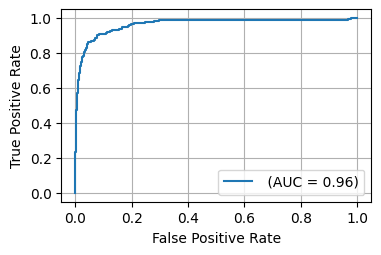

In [31]:
print(              blob_path + run_prefix + 'filtered_blob_stats_tagged.pkl')
plot_roc_blob_stats(blob_path + run_prefix + 'filtered_blob_stats_tagged.pkl')
plt.grid()

##### Heavy atom peak heights
See `vae_metric_heavy_atom_peak_value.ipynb`

In [32]:
print(eps)

0.02
